# AML Exam (Skin disease image classification)

# 1. Importing Libraries / Defining Global Functions

In [16]:
import random # Generating Random Numbers
import os # Loading images
import shutil # Copying and moving images
import numpy as np # Handling big data
import cv2 # Image loading and augmenting
from matplotlib import pyplot as plt # Visualizing Data
import pickle # Saving/loading models

# Remove unneccesary warning messages
import warnings
warnings.filterwarnings("ignore")

# Gathering model results
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# .DS_Store and .ipynb_checkpoints was generated automatically
# throughout this project, and this would mess up our loops when
# loading images, this function makes sure the loaded list deletes
# theese files to prevent problems.
def remove_unwanted_folders(folder):
    if ".DS_Store" in folder:
        folder.remove(".DS_Store")
    if ".ipynb_checkpoints" in folder:
        folder.remove(".ipynb_checkpoints")

In [17]:
# .DS_Store and .ipynb_checkpoints was generated automatically
# throughout this project, and this would mess up our loops when
# loading images, this function makes sure the loaded list deletes
# theese files to prevent problems.
def remove_unwanted_folders(folder):
    if ".DS_Store" in folder:
        folder.remove(".DS_Store")
    if ".ipynb_checkpoints" in folder:
        folder.remove(".ipynb_checkpoints")

# 2. Augmenting Data

## • Augmenting Data to get more samples.

In [18]:
class Generate_folders():
    """Class to generate all class folders inside a new directory:
       Parameters:
       - original_data_path: path to original dataset containing all disease folders.
       - original_data_path type: str
       
       - save_data_path: path to folder where all folders will be (has to be empty)
       - save_data_path type: str"""

    def __init__(self, original_data_path, save_data_path):
        self.o_data_path = original_data_path
        self.s_data_path = save_data_path
        
    def generate_folders(self):
        """This function generates train, validation and test folders containing all target classes."""

        # Function for creating folders.
        def create_folders():
            # Define folders to generate
            folders = ["train","val","test"]

            for folder in folders:
                # Create new folders with the name of train, val, or test
                os.mkdir(os.path.join(self.s_data_path,folder))

                # For each folder, create new folder with each class labels (diseases)
                for disease in disease_folder:
                    os.mkdir(os.path.join(self.s_data_path,folder,disease))
            print("Folders Created!")
        
        # Gathering parameters (paths) into variables.
        disease_path = self.o_data_path
        disease_folder = os.listdir(disease_path)
        remove_unwanted_folders(disease_folder)
        
        save_path = self.s_data_path
        save_folder = os.listdir(self.s_data_path)
        remove_unwanted_folders(save_folder)
        
        # Check if the Target folder is not empty
        if save_folder != []:
            # If the target folder is not empty, prompt the user to overwrite or not
            print("Save folder not empty!")
            u_input = input("Do you wish to overwrite? (y/n)")
            
            # If they decide to overwrite, remove train, val, test folders
            if u_input == "y":
                for folder in save_folder:
                    shutil.rmtree(os.path.join(save_path,folder))
                    
                # Recreate folders
                create_folders()
            else:
                # If they do not decide to overwrite:
                print("Please delete folders and try again.") 
        else:
            # If the Target folder is empty, generate folders.
            create_folders()

In [20]:
folder_generator = Generate_folders("./Data/original_data","./Data/test/")

In [24]:
folder_generator.generate_folders()

Folders Created!


In [ ]:
del(augmentor)

## • Defining Augmentation Functions

In [26]:
def save_Augmented_Image(save_path,img):
    cv2.imwrite(save_path,img)
    
def generate_r_value(min_value, max_value, d_type="int"):
    if d_type == "int":
        rand_n = random.randint(min_value, max_value)
    elif d_type == "float":
        rand_n = random.uniform(min_value, max_value)
    return rand_n

## • Loading directories

In [4]:
# Get list of all disease folders in data
original_data_path = "./Data/original_data/"
original_data_folder = os.listdir(original_data_path)
remove_unwanted_folders(original_data_folder)

augmented_data_path = "./Data/test/"
#augmented_data_folder = os.listdir(augmented_data_path)

## • Augmenting Images

In [ ]:
# Specify Parameters
copies = 2

brightness_min = -60
brightness_max = 90

contrast_min = 0.5
contrast_max = 1.7


id_counter = 0
for disease in original_data_folder: # Looping over all disease folders
    # Get all images inside of current disease folder
    images = os.listdir(os.path.join(original_data_path,disease))

    # Loading each image in folder
    for current_image in images:
        # Get full path of current image
        current_image_full_path = os.path.join(original_data_path, disease, current_image)
        
        
        # ----- Augment Orginal ----
        id_counter +=1
        current_image_cv2 = cv2.imread(current_image_full_path)                              
        save_Augmented_Image(os.path.join(augmented_data_path, disease, f"o_{id_counter}_"+current_image),current_image_cv2)
        
        # Adjust Brightness
        for x in range(copies):
            id_counter +=1
            brightness_image = cv2.convertScaleAbs(current_image_cv2, alpha=1, beta=generate_r_value(brightness_min,brightness_max))
            save_Augmented_Image(os.path.join(augmented_data_path,disease,f"o_b_{id_counter}_"+current_image),brightness_image)
        
        # Adjust Contrast
        for x in range(copies):
            id_counter +=1
            contrast_image = cv2.convertScaleAbs(current_image_cv2, alpha=generate_r_value(contrast_min, contrast_max,"float"), beta=0)
            save_Augmented_Image(os.path.join(augmented_data_path,disease,f"o_c_{id_counter}_"+current_image),contrast_image)
        
        
        
        # ---- FLip Horizontal ----
        # Flip Horizontal
        id_counter +=1
        horizontal_flip_image = cv2.flip(current_image_cv2,1)
        save_Augmented_Image(os.path.join(augmented_data_path,disease,f"hF_{id_counter}_"+current_image),horizontal_flip_image)
        
        # Adjust Brightness
        for x in range(copies):
            id_counter +=1
            brightness_image = cv2.convertScaleAbs(horizontal_flip_image, alpha=1, beta=generate_r_value(brightness_min,brightness_max))
            save_Augmented_Image(os.path.join(augmented_data_path,disease,f"hf_b_{id_counter}_"+current_image),brightness_image)
        
        # Adjust Contrast
        for x in range(copies):
            id_counter +=1
            contrast_image = cv2.convertScaleAbs(horizontal_flip_image, alpha=generate_r_value(contrast_min, contrast_max, "float"), beta=0)
            save_Augmented_Image(os.path.join(augmented_data_path,disease,f"hf_c_{id_counter}_"+current_image),contrast_image)
            
           
        
        # ---- FLip Vertical ---
        # Flip Vertical
        id_counter +=1
        vertical_flip_image = cv2.flip(current_image_cv2,0)
        save_Augmented_Image(os.path.join(augmented_data_path,disease,f"vF_{id_counter}_"+current_image),vertical_flip_image)
        
        # Adjust Brightness
        for x in range(copies):
            id_counter +=1
            brightness_image = cv2.convertScaleAbs(vertical_flip_image, alpha=1, beta=generate_r_value(brightness_min, brightness_max))
            save_Augmented_Image(os.path.join(augmented_data_path,disease,f"vf_b_{id_counter}_"+current_image),brightness_image)
        
        # Adjust Contrast
        for x in range(copies):
            id_counter +=1
            contrast_image = cv2.convertScaleAbs(vertical_flip_image, alpha=generate_r_value(contrast_min , contrast_max, "float"), beta=0)
            save_Augmented_Image(os.path.join(augmented_data_path,disease,f"vf_c_{id_counter}_"+current_image),contrast_image)    

## • Saving augmented data into train, validation and test

### • Loading directory

In [52]:
# Get list of all disease folders in data
original_data_path = "./Data/test/"
original_data_folder = os.listdir(original_data_path)

remove_unwanted_folders(original_data_folder)
print(original_data_folder)

[]


### • Calculating train, test, validation sizes and moving images

In [77]:
for disease in original_data_folder:
    # Get all images inside each corresponding disease folder
    disease_images = os.listdir(os.path.join(original_data_path,disease))
    remove_unwanted_folders(disease_images)
    images = np.array(disease_images)
    images.shuffle()
    
# Calculating Train, Validation and Test image count
    train_partition = int(len(images)*.7)
    validation_partition = int(len(images)*.2)
    test_partition = int(len(images)*.1)
    
# Empty lists to store all numbers in range into a list.
    train_partition_indexes = []
    validation_partition_indexes = []
    test_partition_indexes = []
    

# Array of Train images from partition.
    for x in range(0,train_partition):
        train_partition_indexes.append(x)
    train_image_array = np.take(images,train_partition_indexes)
    
# Array of Validation images from partition.
    for x in range(train_partition, train_partition + validation_partition):
        validation_partition_indexes.append(x)
    validation_image_array = np.take(images, validation_partition_indexes)
    
# Array of Test images from partition.
    for x in range(train_partition + validation_partition , train_partition + validation_partition + test_partition):
        test_partition_indexes.append(x)
    test_image_array = np.take(images, test_partition_indexes)
        

# Defining path to new folders
    train_folder_path = "./Data/augmented_data/train/"
    validation_folder_path = "./Data/augmented_data/val/"
    test_folder_path = "./Data/augmented_data/test/"
    
    
# Moving images to their respective train, validation and test folders
    # • Train Images
    for current_image in train_image_array:
        current_image_full_path = os.path.join(original_data_path, disease, current_image)
        shutil.copyfile(current_image_full_path, os.path.join(train_folder_path, disease, current_image))

    # • Validation Images
    for current_image in validation_image_array:
        current_image_full_path = os.path.join(original_data_path, disease, current_image)
        shutil.copyfile(current_image_full_path, os.path.join(validation_folder_path, disease, current_image))
    
    # • Test Images
    for current_image in test_image_array:
        current_image_full_path = os.path.join(original_data_path, disease, current_image)
        shutil.copyfile(current_image_full_path, os.path.join(test_folder_path, disease, current_image)) 

# 3. Data Processor Class

In [210]:
class DataProcessor:
    __doc__ = "Class that assists with different data processing actions."
    
    def __init__(self, original_data_path, target_folder):
        self.original_path = original_data_path
        self.classes = os.listdir(self.original_path)
        remove_unwanted_folders(self.classes)
        
        self.target_path = target_folder
        self.target_folder = os.listdir(self.target_path)
        remove_unwanted_folders(self.target_folder)
        
        print("Data Processor successfully created!")
    
    def generate_x_y(self, image_folder, shuffle="True"):
        # Creates temporary lists to store images
        temp_x = []
        temp_y = []

        # Gathering Training Data
        for class_label in self.classes:
            images = os.listdir(os.path.join(image_folder, class_label))
            for current_image in images:
                # Load every image in current class folder as cv2 image
                current_image_full_path = os.path.join(image_folder, class_label, current_image)
                current_image = cv2.imread(current_image_full_path)
                current_image = cv2.resize(current_image,(224,224))

                # Adds current image to list, flattened.
                temp_x.append(current_image.flatten())
                temp_y.append(class_label)
                
        # Convert from list to array, len(temp_x) is the amount of images (array rows) and -1 is the total lenght of values (coloumns)
        # Theese values are divided by 255 to convert from standard RGB 0-255 into a more machine learning friendly 0-1 values.
        temp_x = np.array(temp_x).reshape(len(temp_x), -1)/255
        temp_y = np.array(temp_y)
        
        def unison_shuffle(self, array_x, array_y):
            assert len(array_x) == len(array_y)
            shuffle = np.random.permutation(len(array_y))
            return array_x[shuffle], Y_array[shuffle]
        
        if shuffle == True:
            temp_x , temp_y = self.unison_shuffle(temp_x, temp_y)
        return temp_x, temp_y
    generate_x_y.__doc__ = '''This function will generate X and Y data from chosen folder.
                                Parameters:
                                data.generate_image_array(path to image folder as string) -> X, Y'''
    
    def generate_folders(self):
        """This function generates train, validation and test folders containing all target classes."""

        # Function for creating folders.
        def create_folders(target_folder):
            # Define folders to generate
            folders = ["train","val","test"]

            for folder in folders:
                # Create new folders with the name of train, val, or test
                os.mkdir(os.path.join(self.target_path, folder))

                # For each folder, create new folder with each class labels (diseases)
                for class_label in self.classes:
                    os.mkdir(os.path.join(self.target_path, folder, class_label))
            print("Train, Val and test folders created!")
        
        # Check if the Target folder is not empty
        save_folder = self.target_folder
        if save_folder != ["temp"]:
            if save_folder != []:
                # If the target folder is not empty, prompt the user to overwrite or not
                print("Save folder not empty!")
                u_input = input("Do you wish to overwrite? (y/n)")

                # If they decide to overwrite, remove train, val, test folders
                if u_input == "y":
                    for folder in self.target_folder:
                        shutil.rmtree(os.path.join(self.target_path, folder))

                    # Recreate folders
                    create_folders(self.target_folder)
                else:
                    # If they do not decide to overwrite:
                    print("Please delete folders and try again.") 
            else:
                # If the Target folder is empty, generate folders.
                create_folders(self.target_folder)
        else:
            # If the Target folder contains only temp.
            create_folders(self.target_folder)
            
            
            self.target_folder = os.listdir(self.target_path)
            remove_unwanted_folders(self.target_folder)
    
    def move_images(self):
        target_folder = self.target_folder
        if "train" in target_folder and "val" in target_folder and "train" in target_folder:
            for class_label in self.classes:
                # Get all images inside each corresponding disease folder
                images = os.listdir(os.path.join(self.target_path,"temp",class_label))
                remove_unwanted_folders(images)
                images = np.array(images)
                np.random.shuffle(images)

            # Calculating Train, Validation and Test image count
                train_partition = int(len(images)*.7)
                validation_partition = int(len(images)*.2)
                test_partition = int(len(images)*.1)

            # Empty lists to store all numbers in range into a list.
                train_partition_indexes = []
                validation_partition_indexes = []
                test_partition_indexes = []

            # Array of Train images from partition.
                for x in range(0,train_partition):
                    train_partition_indexes.append(x)
                train_image_array = np.take(images,train_partition_indexes)

            # Array of Validation images from partition.
                for x in range(train_partition, train_partition + validation_partition):
                    validation_partition_indexes.append(x)
                validation_image_array = np.take(images, validation_partition_indexes)

            # Array of Test images from partition.
                for x in range(train_partition + validation_partition , train_partition + validation_partition + test_partition):
                    test_partition_indexes.append(x)
                test_image_array = np.take(images, test_partition_indexes)


            # Moving images to their respective train, validation and test folders
                # • Train Images
                for current_image in train_image_array:
                    current_image_full_path = os.path.join(self.target_path,"temp",class_label, current_image)
                    shutil.copyfile(current_image_full_path, os.path.join(self.target_path,"train",class_label, current_image))

                # • Validation Images
                for current_image in validation_image_array:
                    current_image_full_path = os.path.join(self.target_path,"temp",class_label, current_image)
                    shutil.copyfile(current_image_full_path, os.path.join(self.target_path,"val",class_label, current_image))

                # • Test Images
                for current_image in test_image_array:
                    current_image_full_path = os.path.join(self.target_path, "temp", class_label, current_image)
                    shutil.copyfile(current_image_full_path, os.path.join(self.target_path,"test",class_label,current_image))
            print("All images moved into respective train, val and test folders!")
            shutil.rmtree(os.path.join(self.target_path, "temp"))
        else:
            print("Folder is missing train, val, and test folders. run generate_folders() first!")
        
    
    def augment_images(self, copies=2):
        # Defining Functions used for augmentation
        def save_Augmented_Image(save_path,img):
            cv2.imwrite(save_path,img)

        def generate_r_value(min_value, max_value, d_type="int"):
            if d_type == "int":
                rand_n = random.randint(min_value, max_value)
            elif d_type == "float":
                rand_n = random.uniform(min_value, max_value)
            return rand_n
    
        # Specify Parameters
        brightness_min = -60
        brightness_max = 90
        contrast_min = 0.5
        contrast_max = 1.7

        # Create temporary folder
        os.mkdir(os.path.join(self.target_path, "temp"))
        
        id_counter = 0
        for class_label in self.classes: # Looping over all disease folders
            os.mkdir(os.path.join(self.target_path, "temp", class_label))
            self.target_folder = os.listdir(self.target_path)
            # Get all images inside of current disease folder

            images = os.listdir(os.path.join(self.original_path, class_label))

            # Loading each image in folder
            for current_image in images:
                # Get full path of current image
                current_image_full_path = os.path.join(self.original_path, class_label, current_image)

                # ----- Augment Orginal ----
                id_counter +=1
                current_image_cv2 = cv2.imread(current_image_full_path)                              
                save_Augmented_Image(os.path.join(self.target_path, "temp", class_label, f"o_{id_counter}_"+current_image), current_image_cv2)

                # Adjust Brightness
                for x in range(copies):
                    id_counter +=1
                    brightness_image = cv2.convertScaleAbs(current_image_cv2, alpha=1, beta=generate_r_value(brightness_min,brightness_max))
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"o_b_{id_counter}_"+current_image),brightness_image)
                # Adjust Contrast
                for x in range(copies):
                    id_counter +=1
                    contrast_image = cv2.convertScaleAbs(current_image_cv2, alpha=generate_r_value(contrast_min, contrast_max,"float"), beta=0)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"o_c_{id_counter}_"+current_image),contrast_image)


                # ---- FLip Horizontal ----
                # Flip Horizontal
                id_counter +=1
                horizontal_flip_image = cv2.flip(current_image_cv2,1)
                save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"hF_{id_counter}_"+current_image),horizontal_flip_image)

                # Adjust Brightness
                for x in range(copies):
                    id_counter +=1
                    brightness_image = cv2.convertScaleAbs(horizontal_flip_image, alpha=1, beta=generate_r_value(brightness_min,brightness_max))
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"hf_b_{id_counter}_"+current_image),brightness_image)
                # Adjust Contrast
                for x in range(copies):
                    id_counter +=1
                    contrast_image = cv2.convertScaleAbs(horizontal_flip_image, alpha=generate_r_value(contrast_min, contrast_max, "float"), beta=0)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"hf_c_{id_counter}_"+current_image),contrast_image)


                # ---- FLip Vertical ---
                # Flip Vertical
                id_counter +=1
                vertical_flip_image = cv2.flip(current_image_cv2,0)
                save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"vF_{id_counter}_"+current_image),vertical_flip_image)

                # Adjust Brightness
                for x in range(copies):
                    id_counter +=1
                    brightness_image = cv2.convertScaleAbs(vertical_flip_image, alpha=1, beta=generate_r_value(brightness_min, brightness_max))
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"vf_b_{id_counter}_"+current_image),brightness_image)
                # Adjust Contrast
                for x in range(copies):
                    id_counter +=1
                    contrast_image = cv2.convertScaleAbs(vertical_flip_image, alpha=generate_r_value(contrast_min , contrast_max, "float"), beta=0)
                    save_Augmented_Image(os.path.join(self.target_path, "temp", class_label,f"vf_c_{id_counter}_"+current_image),contrast_image)
        print("All augmented images saved to temp folder.")
        u_input = input("Do you wish to move theese into train, val, test using the move_images() function? (y/n)")
        if u_input == "y":
            self.move_images()

In [212]:
data_p = DataProcessor("./Data/original_data/","./Data/test/")

Data Processor successfully created!


In [214]:
data_p.generate_folders()

Train, Val and test folders created!


In [215]:
data_p.augment_images(copies=1)

All augmented images saved to temp folder.


Do you wish to move theese into train, val, test using the move_images() function? (y/n) y


All images moved into respective train, val and test folders!


In [213]:
data_p.move_images()

Folder is missing train, val, and test folders. run generate_folders() first!


In [33]:
train_x , train_y = data_p.generate_x_y("./Data/original_data/")

In [209]:
del(data_p)

NameError: name 'd' is not defined

In [225]:
class Data_Loader:
    __doc__ = "Class used to convert directory of disease folders with images into practical numpy arrays for ML!"
    
    def unison_shuffle(self, X_array, Y_array):
        assert len(X_array) == len(Y_array)
        shuffle = np.random.permutation(len(X_array))
        return X_array[shuffle], Y_array[shuffle]
    
    def generate_image_array(self, folder_path):
        
        self.folder_path = folder_path
        self.folder = os.listdir(self.folder_path)
        remove_unwanted_folders(self.folder)
    
        # Creates temporary lists to store images
        temp_x = []
        temp_y = []

        # Gathering Training Data
        for disease in self.folder:
            images = os.listdir(os.path.join(self.folder_path,disease))
            for current_image in images:
                # Load every image in current disease folder as cv2 image
                current_image_full_path = os.path.join(self.folder_path, disease, current_image)
                current_image = cv2.imread(current_image_full_path)
                current_image = cv2.resize(current_image,(224,224))

                # Adds current image to list, flattened.
                temp_x.append(current_image.flatten())
                temp_y.append(disease)
                
        # Convert from list to array, len(temp_x) is the amount of images (array rows) and -1 is the total lenght of values (coloumns)
        # Theese values are divided by 255 to convert from standard RGB 0-255 into a more machine learning friendly 0-1 values.
        temp_x = np.array(temp_x).reshape(len(temp_x), -1)/255
        temp_y = np.array(temp_y)
        
        temp_x , temp_y = self.unison_shuffle(temp_x, temp_y)
        return temp_x, temp_y
    
    # Defind Documentation for 
    generate_image_array.__doc__ = '''This function converts all images located in disease folders into X and Y numpy arrays.
                                      Example:
                                      data.generate_image_array(path to training data folder as string)
                                      Returns -> X, Y'''

# 4. Random Forest

## • Importing Libraries

In [223]:
from sklearn.ensemble import RandomForestClassifier

## • Load processed data

In [226]:
train_path = "./Data/augmented_data/train/" # Augmented Data
val_path = "./Data/augmented_data/val/" # Augmented Data
test_path = "./Data/augmented_data/test/" # Augmented Data

# Create Data_Loader object
data = Data_Loader()

In [227]:
# Generate data split from data class object.
train_x ,train_y = data.generate_image_array(train_path)
test_x ,test_y = data.generate_image_array(test_path)

## • Visualizing Loaded Data

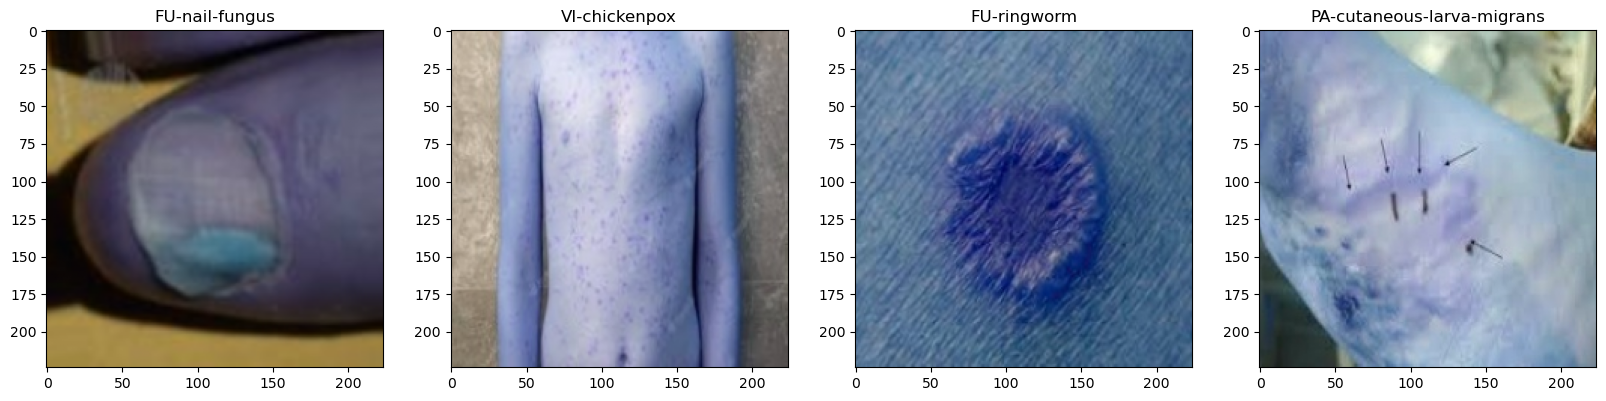

In [69]:
# Plotting Sample of the dataset
plot_images = train_x.reshape((len(train_x),224,224,3))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# Looping over 4 images and plotting them
for index, image in enumerate(train_x[:4]):
    ax[index].imshow(plot_images[index])
    ax[index].title.set_text(train_y[index])
    
# Open-CV used BGR as standard, which is the reason colors are off

## • Define Model

In [ ]:
rfc = RandomForestClassifier(random_state=1)

## • Train Model

In [ ]:
rfc.fit(train_x, train_y)

## • Gathering Model Results

In [14]:
%%time
# __min __s (200 images) on Macbook Air m2
# 14min 18s (200 images) on desktop
result_image_count = 200

y_pred_train = rfc.predict(train_x[:result_image_count])
y_pred_test = rfc.predict(test_x[:result_image_count])

CPU times: total: 57min 5s
Wall time: 14min 18s


### • Accuracy Score

In [16]:
print(f"Training accuracy:  {accuracy_score(train_y[:result_image_count], y_pred_train)}")
print(f"Test accuracy:  {accuracy_score(test_y[:result_image_count], y_pred_test)}")

Training accuracy:  0.84
Test accuracy:  0.8


### • Classification Report

In [17]:
c_report = classification_report(test_y[:result_image_count],y_pred_test)
print(c_report)

                            precision    recall  f1-score   support

            BA- cellulitis       0.85      0.79      0.82        29
               BA-impetigo       0.85      0.79      0.81        14
           FU-athlete-foot       0.96      0.92      0.94        24
            FU-nail-fungus       0.81      0.83      0.82        30
               FU-ringworm       0.86      0.70      0.78        27
PA-cutaneous-larva-migrans       0.74      0.74      0.74        19
             VI-chickenpox       0.88      0.88      0.88        33
               VI-shingles       0.53      0.71      0.61        24

                  accuracy                           0.80       200
                 macro avg       0.81      0.79      0.80       200
              weighted avg       0.81      0.80      0.80       200



## • Load model

In [5]:
model_path = "../../Saved_Models/rfc_rbf.h5"
rfc = pickle.load(open(model_path, 'rb'))

CPU times: total: 2.53 s
Wall time: 10.4 s


## • Export model as pickle

In [72]:
%%time
# __min __s on Macbook Air m2
# __min __s on desktop
save_model ="../../Saved_Models/rfc_large_augmented.h5"
pickle.dump(rfc, open(save_model, 'wb'))

## • Predict with model

Actual Class: PA-cutaneous-larva-migrans
Predicted Class: PA-cutaneous-larva-migrans
   --- Correctly Classified ---   
CPU times: total: 11 s
Wall time: 2.84 s


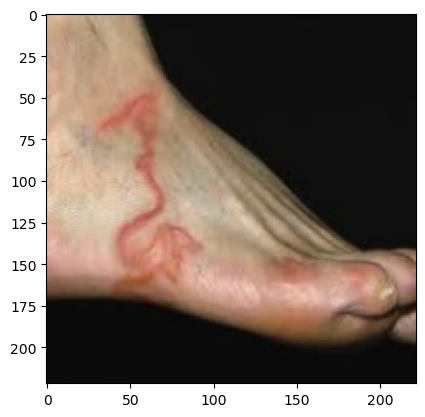

In [18]:
# Load new image to predict
image_path = './Data/original_data/PA-cutaneous-larva-migrans/68_PA-cutaneous-larva-migrans (33).jpg'
actual_class = image_path.split("/")[-2]
predict_image = cv2.imread(image_path)
predict_image = cv2.resize(predict_image, (224,224))
predict_image = np.array(predict_image.flatten()).reshape(1,-1)/255

RGB_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.imshow(RGB_image)

# Get prediction
prediction = rfc.predict(predict_image)[0]
print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {prediction}")

if prediction == actual_class:
    print("   --- Correctly Classified ---   ")
else:
    print("   --- Incorrectly Classified ---   ")

# 5. Convolutional Neural Network (CNN)

## • Importing Tensorflow libraries for CNN model

In [192]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## • Loading data with tensorflow

In [193]:
train = tf.keras.utils.image_dataset_from_directory("./Data/augmented_data/train/",image_size=(224,224))
val = tf.keras.utils.image_dataset_from_directory("./Data/augmented_data/val/", image_size=(224,224))
#test = tf.keras.utils.image_dataset_from_directory("./Data/augmented_data/test/")

Found 12150 files belonging to 8 classes.
Found 3472 files belonging to 8 classes.


In [133]:
data = tf.keras.utils.image_dataset_from_directory("./Data/original_data/",image_size=(224,224))

Found 1157 files belonging to 8 classes.


In [134]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [135]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## • Transforming from regular 0-255 values to 0-1 values

In [194]:
train = train.map(lambda x,y: (x/255, y))
val = val.map(lambda x,y: (x/255, y))
test = test.map(lambda x,y: (x/255, y))

## • Defining Model Structure

In [195]:
cnn = Sequential()

In [222]:
del(cnn)

In [196]:
# Experimental
cnn.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(64, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Flatten())

cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(8, activation='softmax'))
cnn.add(Dropout(0.2))

In [ ]:
# Current model:
cnn.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(64, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Flatten())

cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(8, activation='softmax'))
cnn.add(Dropout(0.2))

In [197]:
cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 26, 26, 32)       

## • Compiling and training model

In [198]:
cnn.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [199]:
logdir='logs'

In [200]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [201]:
%%time
# 29min 30s on Macbook Air m2
# __min __s on desktop
hist = cnn.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
380/380 [==============================] - 76s 199ms/step - loss: 4.7612 - accuracy: 0.3653 - val_loss: 1.5589 - val_accuracy: 0.6293
Epoch 2/5
380/380 [==============================] - 76s 200ms/step - loss: 3.3567 - accuracy: 0.5584 - val_loss: 1.4923 - val_accuracy: 0.7791
Epoch 3/5
380/380 [==============================] - 78s 206ms/step - loss: 2.2934 - accuracy: 0.6436 - val_loss: 1.2902 - val_accuracy: 0.8456
Epoch 4/5
380/380 [==============================] - 83s 219ms/step - loss: 1.6708 - accuracy: 0.6947 - val_loss: 0.8341 - val_accuracy: 0.9087
Epoch 5/5
380/380 [==============================] - 90s 237ms/step - loss: 1.2430 - accuracy: 0.7194 - val_loss: 0.9783 - val_accuracy: 0.8975
CPU times: user 38min 47s, sys: 2min 15s, total: 41min 2s
Wall time: 6min 43s


## • Results

### • Plotting Training Statistics

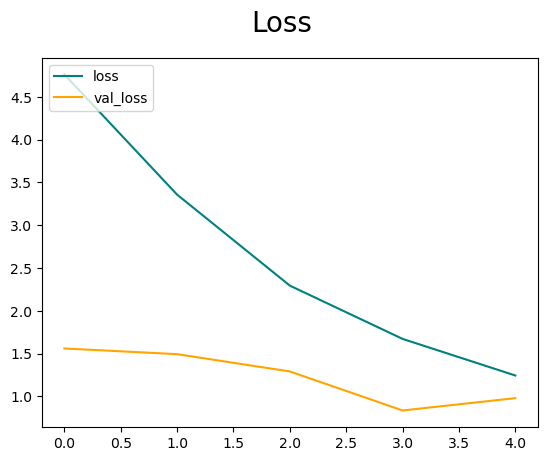

In [202]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

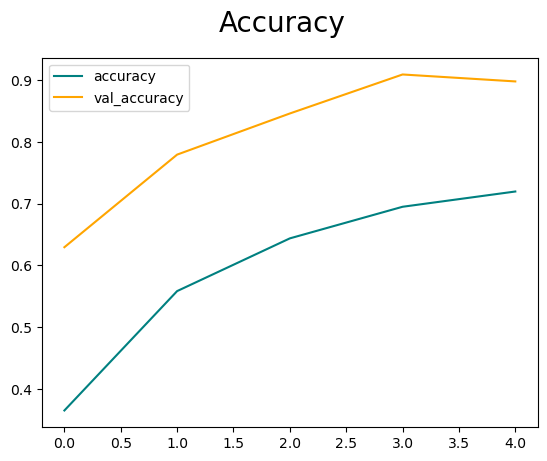

In [203]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### • CNN Model Prediction

#### • Loading unseen image for prediction

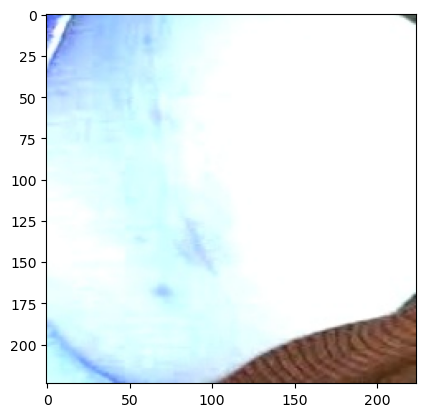

In [220]:
pred_image = cv2.imread('./Data/augmented_data/test/VI-shingles/o_c_5779_136_VI-shingles (10).jpg')
resize = tf.image.resize(pred_image, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

#### • Mapping Classes to indexes

In [212]:
class_map = {
    0: 'BA- cellulitis',
    1: 'BA-impetigo',
    2: 'FU-athlete-foot',
    3: 'FU-nail-fungus',
    4: 'FU-ringworm',
    5: 'PA-cutaneous-larva-migrans',
    6: 'VI-chickenpox',
    7: 'VI-shingles'}

#### • Resizing and prediction

In [221]:
# Resizing image from 0-255 to 0-1
pred_image = resize/255

# Expading dimension for it to fit the model
yhat = cnn.predict(np.expand_dims(pred_image, 0))

# Printing prediction values
print(yhat)

# Finding prediction with highest value
print(f"{class_map[np.argmax(yhat)]}")

1/1 [==============================] - 0s 11ms/step
[[1.0512562e-04 3.5169902e-03 9.8142214e-04 2.7064962e-08 1.2538813e-08
  9.9457318e-01 6.0047250e-04 2.2272102e-04]]
PA-cutaneous-larva-migrans


## • Export model as pickle

In [31]:
%%time
model.save(os.path.join("../../Saved_Models","CNN_V1.h5"))

# 6. Support Vector Machine (SVM)

## • Importing Libraries

In [145]:
from sklearn.svm import SVC

## • Loading Data

In [12]:
train_path = "./Data/data/train/" # Augmented Data
val_path = "./Data/data/val/" # Augmented Data
test_path = "./Data/data/test/" # Augmented Data

# Create Data_Loader object
data = Data_Loader()

In [13]:
# Generate data split from data class object.
train_x ,train_y = data.generate_image_array(train_path)
test_x ,test_y = data.generate_image_array(test_path)

CPU times: total: 26.4 s
Wall time: 29.8 s


## • Visualizing Loaded Data

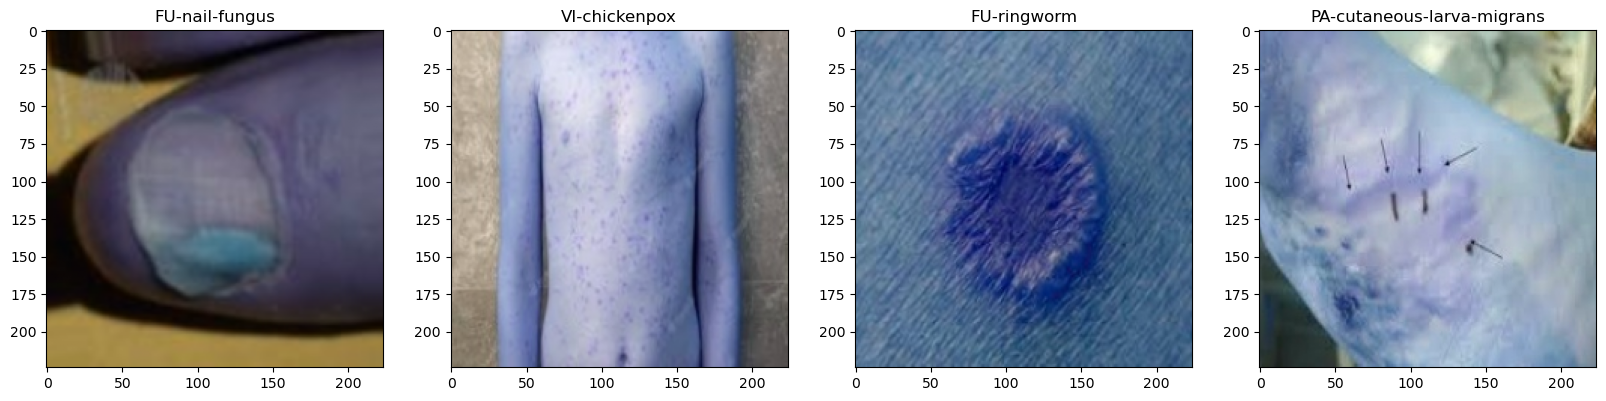

In [69]:
# Plotting Sample of the dataset
plot_images = train_x.reshape((len(train_x),224,224,3))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# Looping over 4 images and plotting them
for index, image in enumerate(train_x[:4]):
    ax[index].imshow(plot_images[index])
    ax[index].title.set_text(train_y[index])
    
# Open-CV used BGR as standard, which is the reason colors are off

## • Training Support Vector Classifier (SVC)

In [70]:
%%time
# __min __s on Macbook Air m2
# 25min 36s on desktop
svc = SVC(kernel="rbf")
svc.fit(train_x,train_y)

CPU times: total: 1h 41min 11s
Wall time: 25min 36s


SVC()

## • Gathering Model Results

In [14]:
%%time
# __min __s (200 images) on Macbook Air m2
# 14min 18s (200 images) on desktop
result_image_count = 200

y_pred_train = svc.predict(train_x[:result_image_count])
y_pred_test = svc.predict(test_x[:result_image_count])

CPU times: total: 57min 5s
Wall time: 14min 18s


### • Accuracy Score

In [16]:
print(f"Training accuracy:  {accuracy_score(train_y[:result_image_count], y_pred_train)}")
print(f"Test accuracy:  {accuracy_score(test_y[:result_image_count], y_pred_test)}")

Training accuracy:  0.84
Test accuracy:  0.8


### • Classification Report

In [17]:
c_report = classification_report(test_y[:result_image_count],y_pred_test)
print(c_report)

                            precision    recall  f1-score   support

            BA- cellulitis       0.85      0.79      0.82        29
               BA-impetigo       0.85      0.79      0.81        14
           FU-athlete-foot       0.96      0.92      0.94        24
            FU-nail-fungus       0.81      0.83      0.82        30
               FU-ringworm       0.86      0.70      0.78        27
PA-cutaneous-larva-migrans       0.74      0.74      0.74        19
             VI-chickenpox       0.88      0.88      0.88        33
               VI-shingles       0.53      0.71      0.61        24

                  accuracy                           0.80       200
                 macro avg       0.81      0.79      0.80       200
              weighted avg       0.81      0.80      0.80       200



## • Load model

In [5]:
model_path = "../../Saved_Models/svc_rbf.h5"
svc = pickle.load(open(model_path, 'rb'))

CPU times: total: 2.53 s
Wall time: 10.4 s


## • Export model as pickle

In [72]:
%%time
# __min __s on Macbook Air m2
# __min __s on desktop
save_model ="../../Saved_Models/SVC_large_augmented.h5"
pickle.dump(svc, open(save_model, 'wb'))

## • Predict with model

Actual Class: PA-cutaneous-larva-migrans
Predicted Class: PA-cutaneous-larva-migrans
   --- Correctly Classified ---   
CPU times: total: 11 s
Wall time: 2.84 s


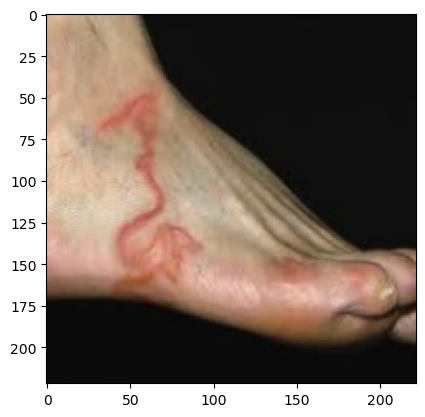

In [18]:
# Load new image to predict
image_path = './Data/original_data/PA-cutaneous-larva-migrans/68_PA-cutaneous-larva-migrans (33).jpg'
actual_class = image_path.split("/")[-2]
predict_image = cv2.imread(image_path)
predict_image = cv2.resize(predict_image, (224,224))
predict_image = np.array(predict_image.flatten()).reshape(1,-1)/255

RGB_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.imshow(RGB_image)

# Get prediction
prediction = svc.predict(predict_image)[0]
print(f"Actual Class: {actual_class}")
print(f"Predicted Class: {prediction}")

if prediction == actual_class:
    print("   --- Correctly Classified ---   ")
else:
    print("   --- Incorrectly Classified ---   ")

# 7. Other Interesting insights

## • Edge detection

### • Plotting Edge Detection Images